# Курсовая работа
## Аналитический отчет для SMM-отдела компании Skillbox

Задача данной курсовой работы – подготовить аналитический ответ для SMM-отдела компании Skillbox. Объектом анализа стал [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). Подключившись к  API VK нужно было выгрузить посты со стены паблика Skillbox за интересующий период, проанализировать влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах) и составить перечень рекомандаций для SMM-отдела по итогам анализа. <br><br>
[1. Выгрузка данных и обоснование выбора периода публикации](#1.-Выгрузка-данных-и-обоснование-выбора-периода-публикации)<br>
[2. Анализ влияния различных факторов на вовлеченность пользователей](#2.-Анализ-влияния-различных-факторов-на-вовлеченность-пользователей)<br>
[3.Выводы на основании рассчитанных данных](#3.-Выводы-на-основании-рассчитанных-данных)

In [17]:
import requests
import json
import pandas as pd
import numpy as np
import re
import pymorphy2
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')
import seaborn as sns
from datetime import datetime, timedelta, timezone
from collections import Counter

### 1. Выгрузка данных и обоснование выбора периода публикации

Выгрузим посты со стены паблика Skillbox за период с 1 марта 2020 года по сегодняшний день. Данный выбор обусловлен желанием сравнить статистику вовлеченности пользователей до ребрендинга компании, который прошел в марте 2021 года (в соц сетях компании Skillbox начали использовать единый дизайн для фото/видео с характерными шрифтами/фоном). 
Отметим посты, созданные до 1 марта 2021 года, комментарием "old_design" и посты, опубликованные после 1 марта 2021 года, комментарием "new_design".
Общую гипотезу можно сформулировать следюущим образом: Существует зависимость количества просмотров/лайков/репостов/комментариев под постами от даты публикации - более новые публикации с обновленным визуалом пользуются бОльшей популярностью, чем более "старые" посты.

In [10]:
def get_posts():
    token = '*******************'
    version = 5.131
    domain = 'skillbox_education'
    offset = 0
    start_date = int(datetime(2020, 3, 1).replace(tzinfo=timezone.utc).timestamp())
    publication_date = 19999999999
    
    all_posts = []

    while start_date < publication_date:
        response = requests.get('https://api.vk.com/method/wall.get',
                                        params={
                                            'access_token': token,
                                            'v': version,
                                            'domain': domain,
                                            'count': 5,
                                            'offset': offset
                                        }
                                        )
        data = response.json()['response']['items']
        publication_date = int(data[-1]['date'])
        offset += 5
        all_posts.extend(data)

    return all_posts

In [11]:
def create_df(posts):

    rows_list = []
    design_change_date = int(datetime(2021, 3, 1).replace(tzinfo=timezone.utc).timestamp())
    for post in posts:
        try:
            if post['attachments'][0]['type']:
                attachments = [i['type'] for i in post['attachments']]
                attachments_count = len(post['attachments'])
            else:
                attachments = 'no attachments'
                attachments_count = 0
        except:
            pass
        rows_list.append([post['text'], post['likes']['count'], post['comments']['count'],
                          post['reposts']['count'], post['views']['count'], post['date'], 
                          attachments, attachments_count])
    
    dataset = pd.DataFrame(rows_list)
    
    dataset.columns = ['text', 'likes', 'comments', 'reposts', 'views',
                    'publication_date', 'attachments', 'attachments_count']
    dataset['design_change'] = np.where(dataset['publication_date'] < design_change_date, 'old_design', 'new_design')
    dataset['publication_date'] = dataset['publication_date']\
                        .apply(lambda x: (datetime.fromtimestamp(x) - timedelta(hours=0))\
                               .strftime('%Y-%m-%d %H:%M:%S'))
    
    return dataset

In [12]:
exported_posts = get_posts()
df = create_df(exported_posts)

In [13]:
df['publication_date'] = pd.to_datetime(df['publication_date'])

### 2. Анализ влияния различных факторов на вовлеченность пользователей

**Зависимость количества просмотров/лайков/комментариев и репостов от времени публикации**

In [14]:
df['hour'] = df['publication_date'].apply(lambda x: x.hour)

In [15]:
design_changes = ['old_design', 'new_design']

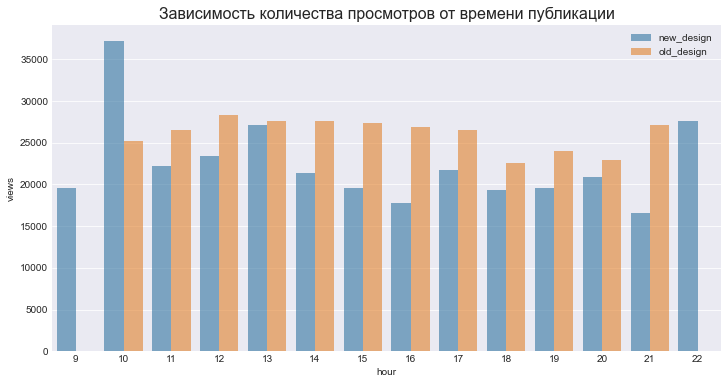

In [18]:
plt.figure(figsize=(12,6))
plt.title("Зависимость количества просмотров от времени публикации", fontsize=16)
g = sns.barplot(data=df, y='views', x='hour', alpha=0.6,  hue='design_change', ci=None)
plt.legend(loc='upper right')
plt.show()

- Можно заметить, что большое количество просмотров выпадает на вечерние и утренние часы (21-22ч и 10 утра); Больше сорока тысяч пользователей просматривают посты около 10 утра.
- С марта 2021 года посты начали публиковаться в 9 утра и 22 часа, ранее в это время публикаций в группе не было. Это может быть связано с желанием привлечь аудиторию в самые "активные" часы.
- В целом, активность участников паблика Skillbox снизилась, что может быть обусловлено ростом популярности других социальных сетей. 

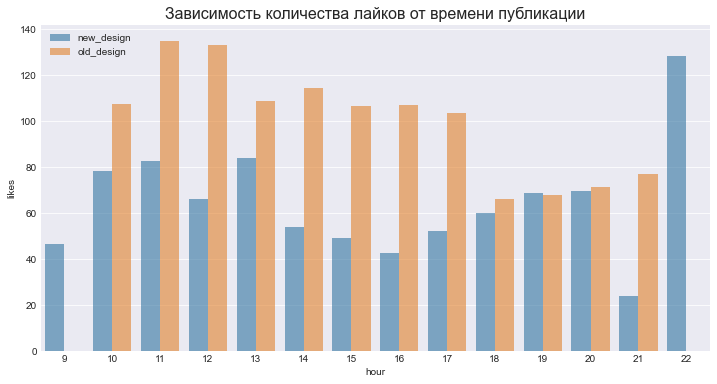

In [19]:
plt.figure(figsize=(12,6))
plt.title("Зависимость количества лайков от времени публикации", fontsize=16)
g = sns.barplot(data=df, y='likes', x='hour', alpha=0.6,  hue='design_change',ci=None)
plt.legend(loc='upper left')
plt.show()

- В качестве дополнения к предыдущему графику можно отметить, что, в целом, до марта 2021 года пользователи чаще лайкали посты группы по сравнению с постами 2021-22 года

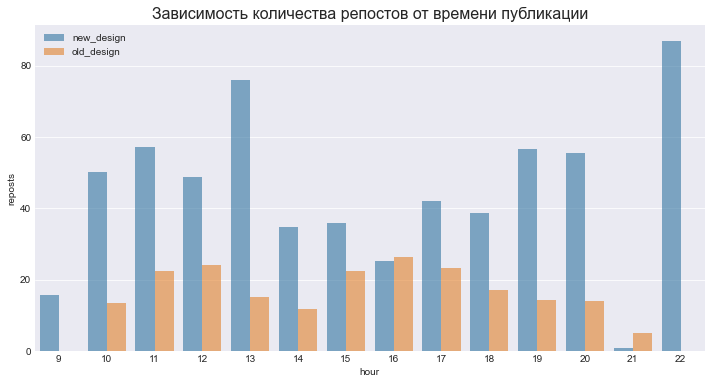

In [20]:
plt.figure(figsize=(12,6))
plt.title("Зависимость количества репостов от времени публикации", fontsize=16)
g = sns.barplot(data=df, y='reposts', x='hour', alpha=0.6,  hue='design_change',ci=None)
plt.legend(loc='upper left')
plt.show()

- Публикации, сделанные в 22 часа пользуются бОльшей популярностью. 
- За последний год люди чаще делают репосты публикаций по сравнению с 2020-началом 2021 года. Это можно связать с желанием людей сохранить полезную информацию, которая публикуется в группе Skillbox, так как на данный момент сервис VK воспринимается как сервис для получения информации, нежели для общения.

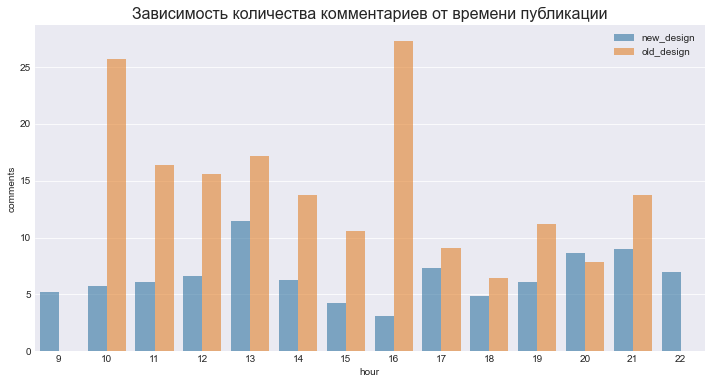

In [21]:
plt.figure(figsize=(12,6))
plt.title("Зависимость количества комментариев от времени публикации", fontsize=16)
g = sns.barplot(data=df, y='comments', x='hour', alpha=0.6,  hue='design_change',ci=None)
plt.legend(loc='upper right')
plt.show()

- В целом, зависимости колличества комментариев в группе от времени публикации постов, не наблюдается. 
- Сравнивая количество комментариев у "старых" и "новых" публикаций, замечаем, что активность в комментариях до марта 2021 была намного выше, чем после обновления визуала группы. Это также подтверждает, что раньше сервис ВК чаще служил людям для общения.

**Зависимость количества репостов/комментариев от тематики постов**<br> <br>
Для определения тематики постов определяем основные хэштеги, которые сопровождают посты и вручную определяем тематику. Таким образом, были выделены следующие темы:
- Маркетинг
- Программирование
- Актуальные Темы
- Анонсы мероприятий
- Студенты (фидбеки, истории карьеры)
- Игры
- Дизайн
- Высшее Образование
- Полезное
и т.д.

In [22]:
df['hashtag'] = df.text.apply(lambda x: re.findall(r'#\w+', x))
df_with_hashtags = df.explode('hashtag')
df_with_hashtags['hashtag'] = df_with_hashtags['hashtag'].apply(lambda x: str(x).lower())
df_with_hashtags = df_with_hashtags[df_with_hashtags['hashtag'].notnull()]

In [23]:
skillbox_hashtags = {'#маркетинг_skillbox' : 'Маркетинг',
                    '#skillbox_Программирование' : 'Программирование',
                    '#неткибербуллингу' : 'Актуальные темы',
                    '#подарок_ангелу' : 'Анонсы мероприятий',
                    '#вам_слово' : "Студенты",
                    '#вамслово_skillbox': 'Студенты',
                    '#skilbox_маркетинг' : 'Маркетинг',
                    '#skillbox_kespa' : 'Актуальные темы',
                    '#skillbox_игра' : 'Игры',
                    '#дизайн_интерьера' : 'Дизайн',
                    '#деньхокку' : 'Актуальные темы',
                    '#skillbox_гейм' : 'Игры',
                    '#анонс_skillbox' : 'Анонсы мероприятий',
                    '#высшее_образование_skillbox' : 'Высшее образование',
                    '#skillbox_высшее_образование' : 'Высшее образование',
                    '#анонс_Skillbox' : 'Анонсы мероприятий',
                    '#skillbox_программирование' : 'Программирование',
                    '#skillbox_управление' : 'Менеджмент/бизнес',
                    '#skillbox_вдохновляет' : 'Полезное',
                    '#skillbox' : 'Skillbox', 
                    '#вамслово_Skillbox' : "Студенты",
                    '#работа_студента_skillbox' : "Студенты", 
                    '#skillbox_психология' : 'Полезное',
                    '#skillbox_геймдев' : 'Игры', 
                    '#работы_студентов_Skillbox': "Студенты",
                    '#в_закладки_skillbox': 'Полезное',
                    '#skillbox_взакладки': 'Полезное',
                    '#взакладкиskillbox': 'Полезное',
                    '#студенты_skillbox': 'Студенты',
                    '#совет_препода_skillbox': 'Полезное',
                    '#skillbox_business_school': 'Высшее образование',
                    '#skillbox_гейм': 'Игры',
                    '#skillbox_вдохновляет': 'Полезное', 
                    '#деньсвятогопатрика': 'Актуальные темы',
                    '#skillbox_вакансии': 'Skillbox', 
                    '#откройсвоелукоморье': 'Актуальные темы',
                    '#программирование_skillbox': 'Программирование', 
                    '#skillbox_untitled': 'Мультимедиа',
                    '#откройсвоёлукоморье': 'Актуальные темы', 
                    '#skillbox_работа': 'Skillbox', 
                    '#skillbox_курсы': 'Полезное' ,
                    '#статья_skillbox': 'Полезное', 
                    '#расписание_skillbox': 'Анонсы мероприятий', 
                    '#skillbox_дизайн': 'Дизайн',
                    '#деньмарио': 'Актуальные темы', 
                    '#skillbox_mba': 'Высшее образование', 
                    '#анонc_skillbox': 'Анонсы мероприятий',
                    '#skillbox_задачки': 'Полезное', 
                    '#skillbox_преподаватели': 'Skillbox',
                    '#skillbox_маркетинг': 'Маркетинг', 
                    '#skillbox_игры': 'Игры', 
                    '#skillbox_игры': 'Игры',
                    '#skillbox_карьерныйплан': 'Полезное',
                    '#skillbox_программирование': 'Программирование',
                    '#skillbox': 'Skillbox', 
                    '#skillbox_трудоустройство': 'Skillbox', 
                    '#skillbox_анонс': 'Анонсы мероприятий',
                    '#совет_препода_skillbox': 'Полезное', 
                    '#вдохновение_skillbox': 'Полезное',
                    '#курсы_skillbox': 'Skillbox', 
                    '#лекторий_skillbox': 'Полезное', 
                    '#лекторий_Skillbox': 'Полезное',
                    '#вкмenucourt': 'Анонсы мероприятий', 
                    '#конкурс_skillbox': 'Анонсы мероприятий', 
                    '#skillbox_маркетинг': 'Маркетинг',
                    '#skilbox_психология': 'Полезное', 
                    '#skillbox_offf': 'Анонсы мероприятий', 
                    '#skillbox_хакатон': 'Анонсы мероприятий',
                    '#skillbox_бизнес': 'Менеджмент/бизнес', 
                    '#skillbox_дизайн': 'Дизайн', 
                    '#skillbox_лояльность': 'Skillbox',
                    '#skillbox_мультимедиа': 'Мультимедиа', 
                    '#инструменты_skillbox': 'Полезное',
                    '#skillbox_совет_препода': 'Полезное', 
                    '#typomania': 'Анонсы мероприятий', 
                    '#offfmoscow': 'Анонсы мероприятий',
                    '#offf_moscow': 'Анонсы мероприятий',
                    '#skillbox_мультимедиа': 'Мультимедиа', 
                    '#skillbox_управление': 'Менеджмент/бизнес',
                    '#высшее_образование_Skillbox': 'Высшее образование',
                    '#работы_студентов_skillbox': 'Студенты',
                    '#студенты_skillbox': "Студенты"
                    }

In [24]:
df_with_hashtags['topic'] = df_with_hashtags['hashtag'].map(skillbox_hashtags)
# df_with_hashtags['topic'] = np.where(df_with_hashtags['topic'].isnull(), 'другое', df_with_hashtags['topic'])

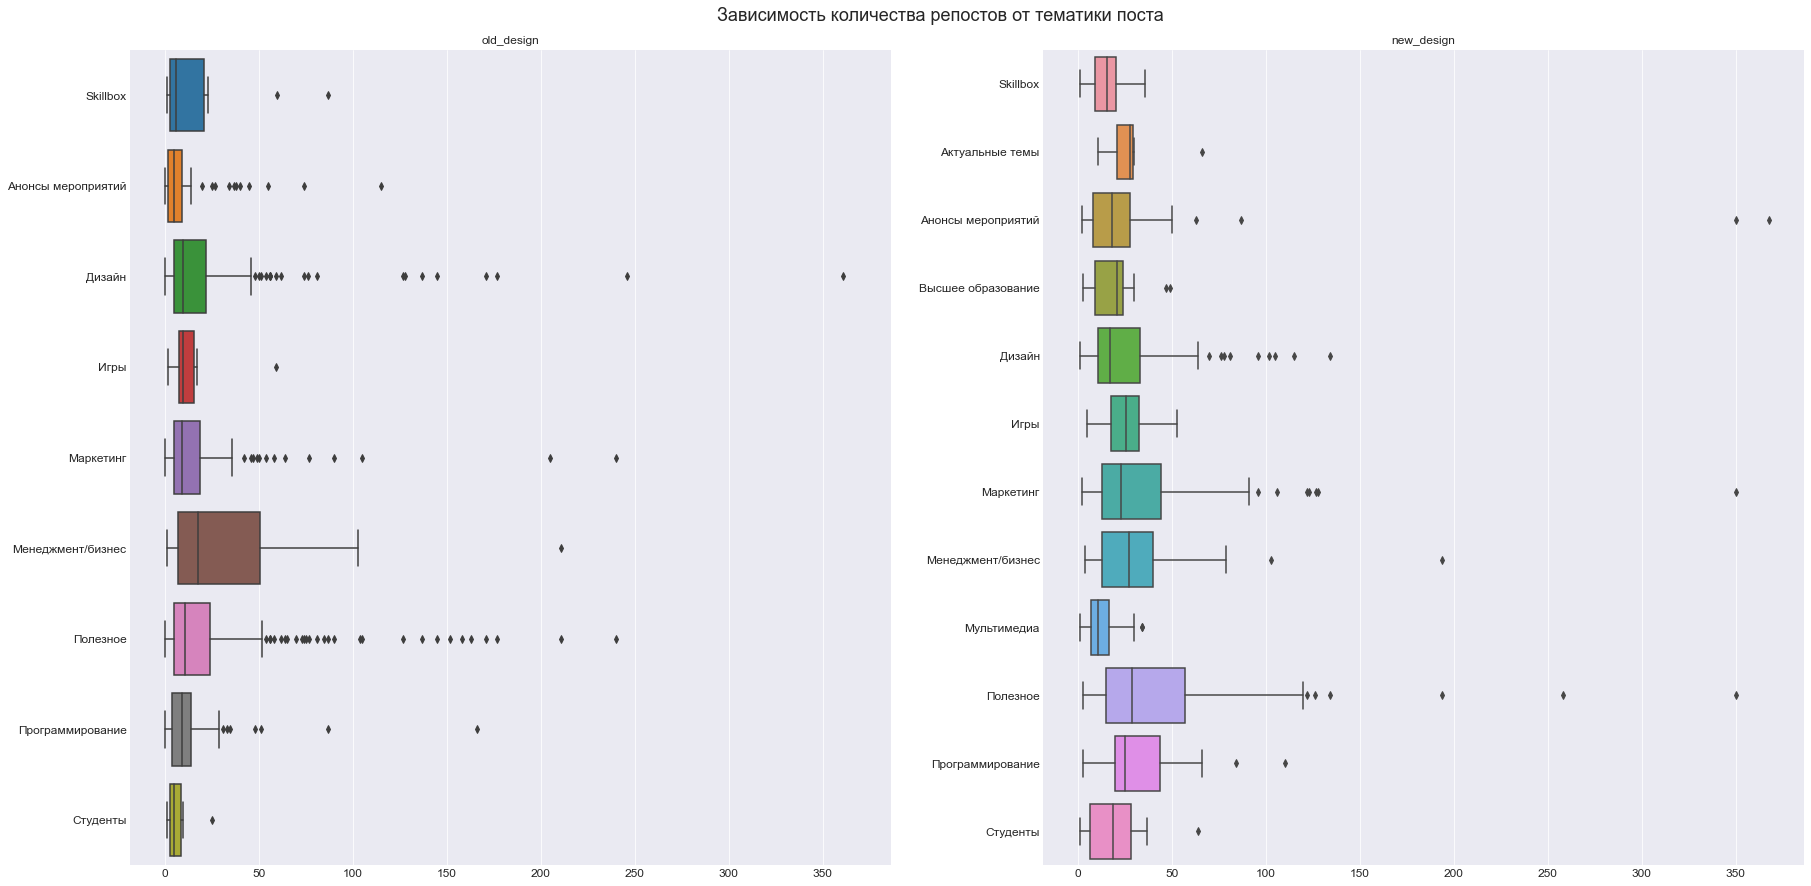

In [25]:
fig, axs = plt.subplots(figsize=(30, 15), nrows=1, ncols=2, sharex=True)
fig.suptitle('Зависимость количества репостов от тематики поста', fontsize=18, y=0.92)

for i in range(len(design_changes)):
    data = df_with_hashtags[df_with_hashtags['design_change'] == design_changes[i]].sort_values('topic')
    g = sns.boxplot(data=data, y='topic', x='reposts', ax = axs[i])
    g.set_title(design_changes[i])
    g.set(xlabel=None, ylabel=None)
    g.tick_params(labelsize=12)
    
plt.show()

На основании рассчитанных значений можно сделать следующие выводы:
- Среднее количество репостов публикаций группы в среднем колеблется от 0 до 50
- Раньше бОльшей популярностью пользовались посты по теме "Менеджмент/Бизнес"
- Также пользователи часто делают репосты публикаций с полезной информацией. Например, с хэштегами #совет_препода_skillbox, #skillbox_задачки, #skillbox_совет_препода

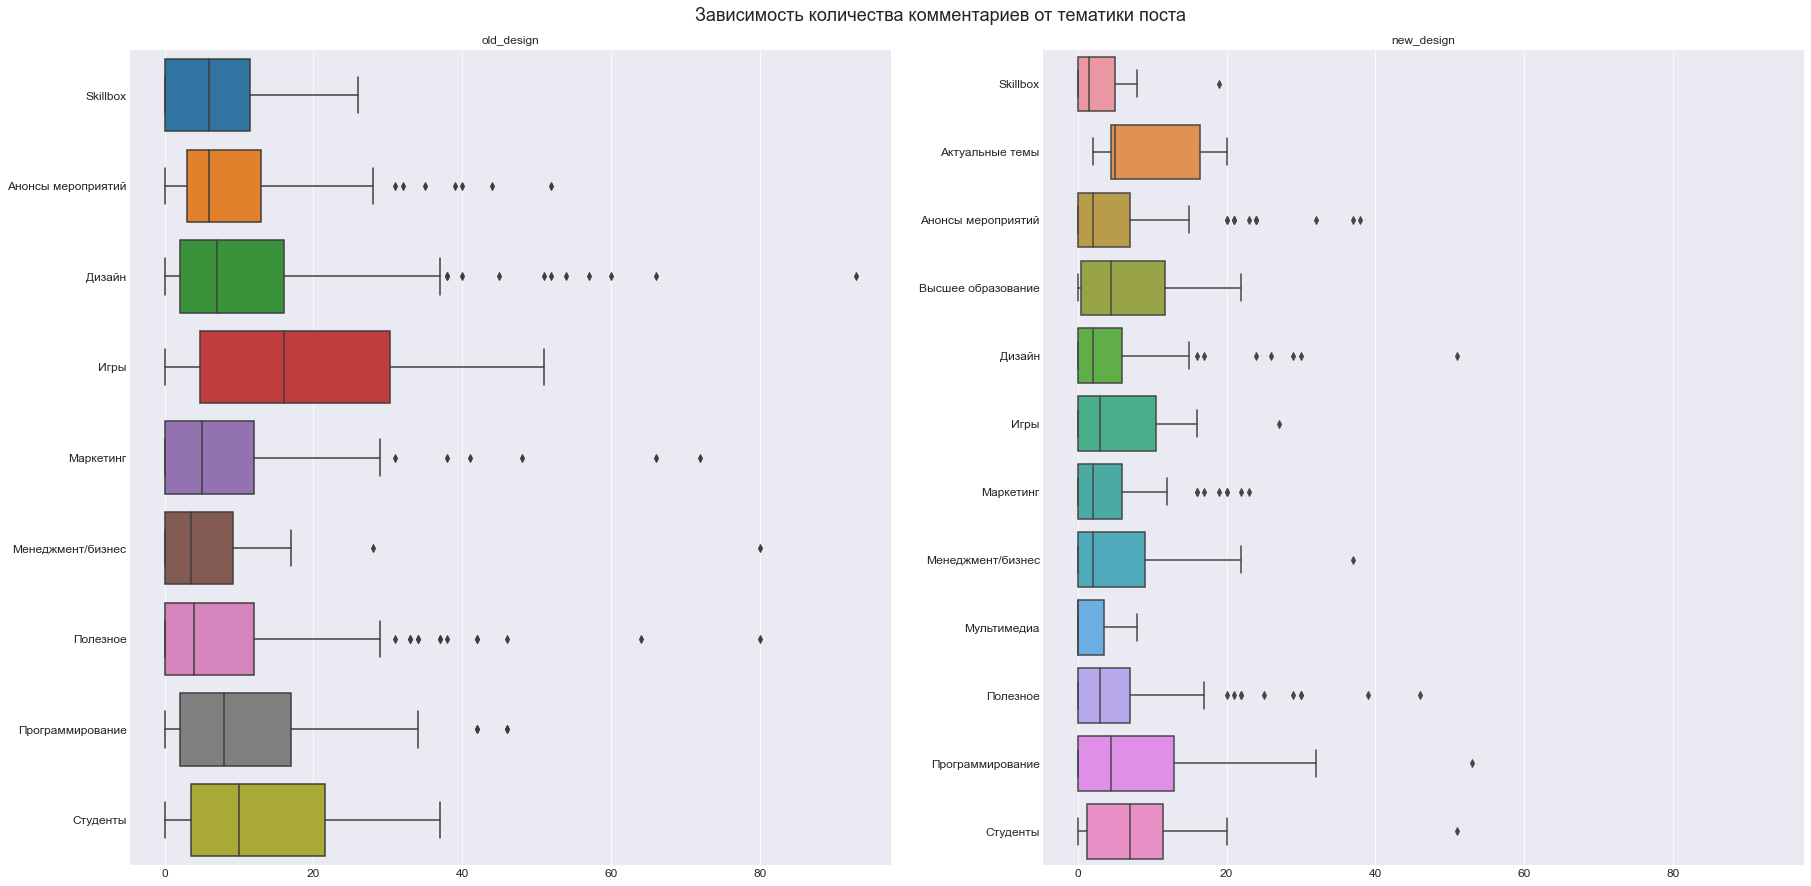

In [26]:
fig, axs = plt.subplots(figsize=(30, 15), nrows=1, ncols=2, sharex=True)
fig.suptitle('Зависимость количества комментариев от тематики поста', fontsize=18, y=0.92)

for i in range(len(design_changes)):
    dev = (df_with_hashtags['comments']-df_with_hashtags['comments'].mean()).abs()
    std = df_with_hashtags['comments'].std()
    data_trimmed = df_with_hashtags[~(dev>3*std)]
    data = data_trimmed[data_trimmed['design_change'] == design_changes[i]].sort_values('topic')
    g = sns.boxplot(data=data, y='topic', x='comments', ax = axs[i])
    g.set_title(design_changes[i])
    g.set(xlabel=None, ylabel=None)
    g.tick_params(labelsize=12)

plt.show()

- До марта 2021 года пользователи чаще комментировали посты по теме "Игры" (#skillbox_гейм, #skillbox_игры)
- Сейчас чаще всего комментируют посты на актуальные темы (#неткибербуллингу, #деньмарио, #деньсвятогопатрика и т.д.). Можно заметить, что до марта 2021 года посты на актуальные темы не публиковались. Это может быть обусловлено падением интереса пользователей к общению в комментариях лишь на темы направлений курсов.

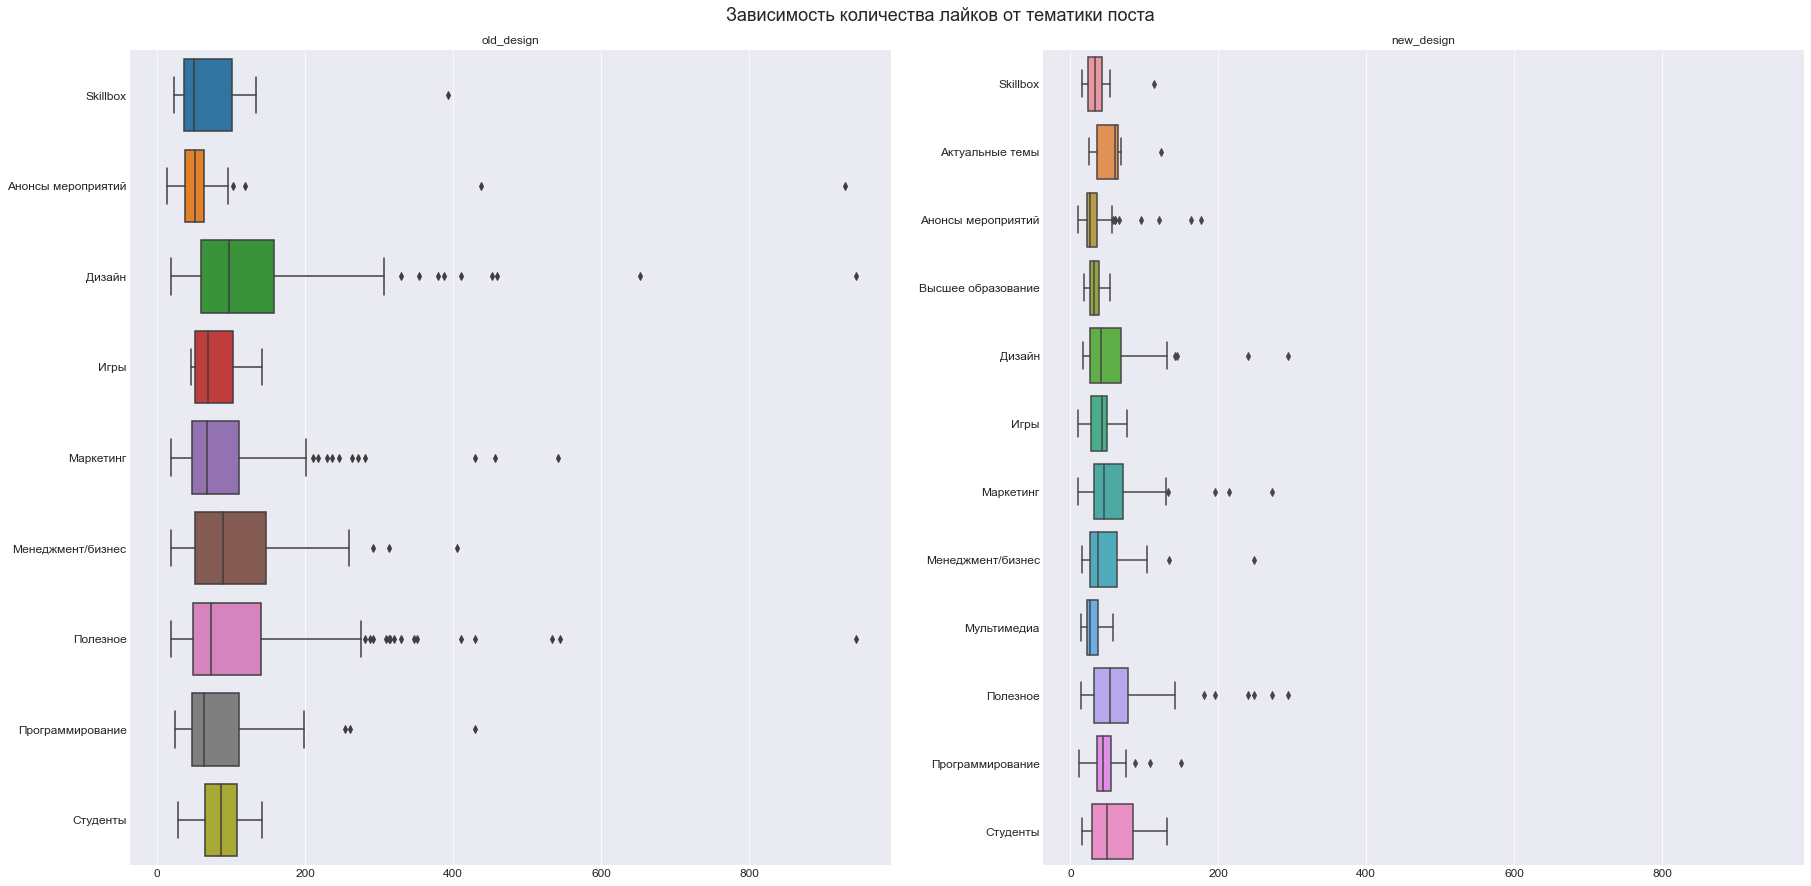

In [27]:
fig, axs = plt.subplots(figsize=(30, 15), nrows=1, ncols=2, sharex=True)
fig.suptitle('Зависимость количества лайков от тематики поста', fontsize=18, y=0.92)

for i in range(len(design_changes)):
    data = df_with_hashtags[df_with_hashtags['design_change'] == design_changes[i]].sort_values('topic')
    g = sns.boxplot(data=data, y='topic', x='likes', ax = axs[i])
    g.set_title(design_changes[i])
    g.set(xlabel=None, ylabel=None)
    g.tick_params(labelsize=12)

plt.show()

Зависимости количества лайков от тематики постов не выявлено

**Зависимость количества лайков от типа и количества аттачментов**<br><br>
Обычно, посты в пабликах в ВК сопровождаются сразу несколькими фото или видео. Для дальнейшего анализа определим типы аттачментов и их количество и построим график распределения количества лайков 

In [28]:
def attachment_count(atatchments):
    att_dict = dict(Counter(atatchments))
    return sorted([[k, v] for k, v in att_dict.items()])

In [29]:
def unnested_list(nested_list):
    return " ".join(nested_list)    

In [30]:
df['att_count'] = df['attachments'].apply(lambda x: " ".join(
                [str(item) for elem in attachment_count(x) for item in elem]))

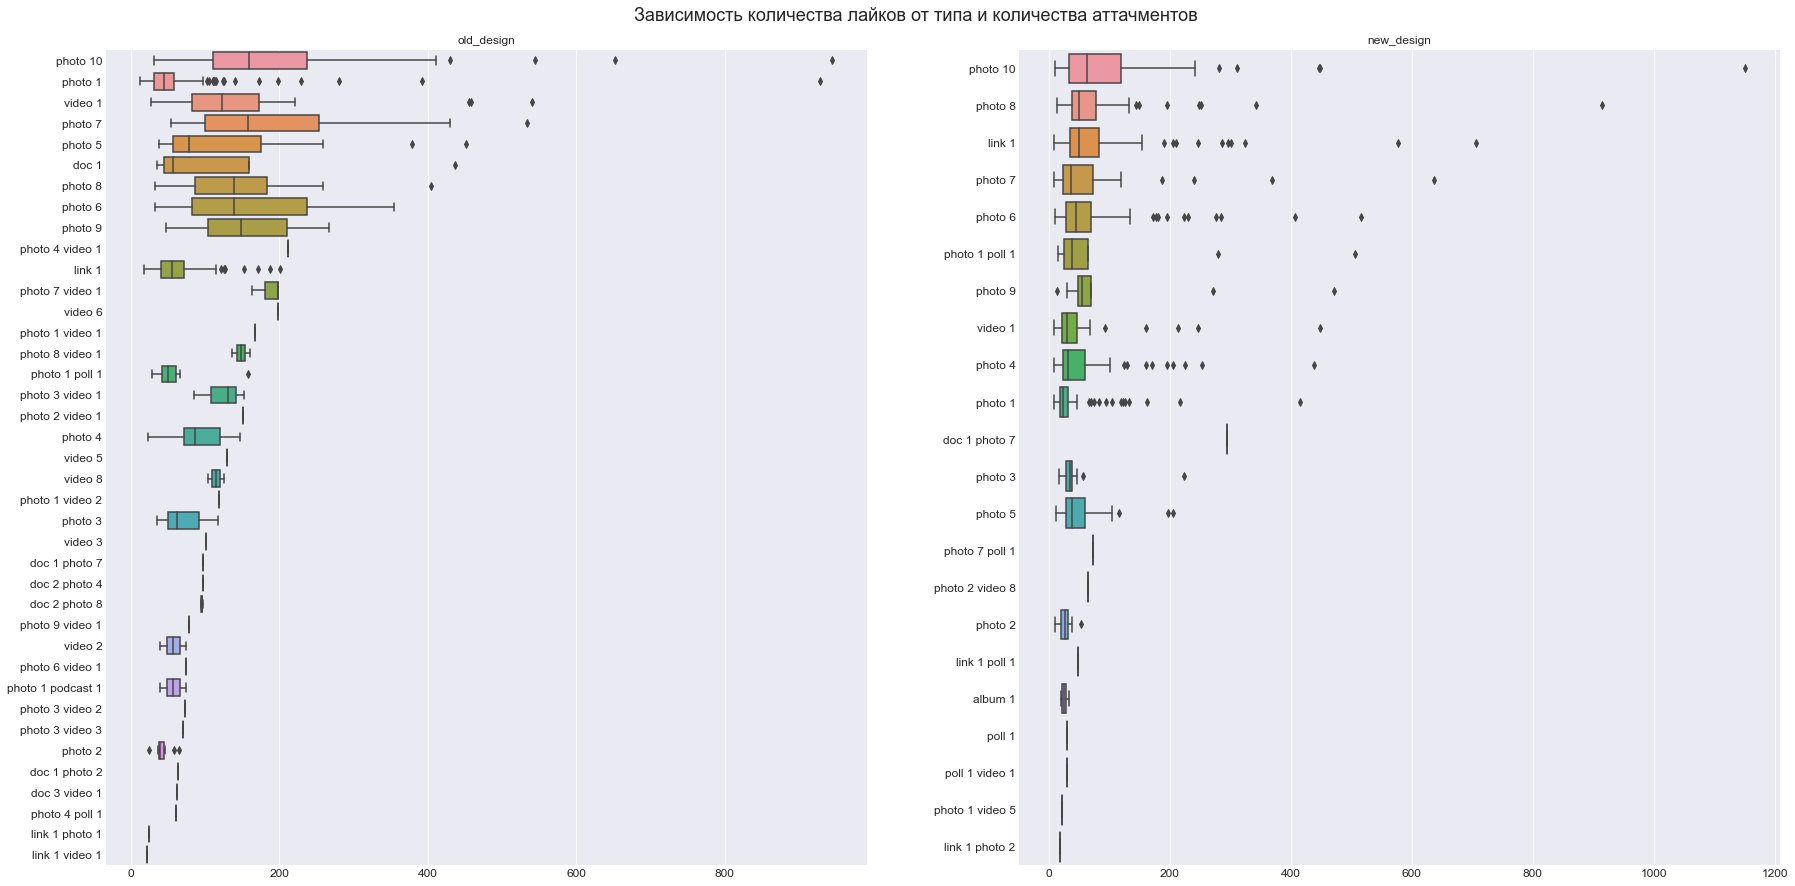

In [31]:
fig, axs = plt.subplots(figsize=(30, 15), nrows=1, ncols=2)
fig.suptitle('Зависимость количества лайков от типа и количества аттачментов', fontsize=18, y=0.92)

for i in range(len(design_changes)):
    data = df[df['design_change'] == design_changes[i]].sort_values('likes', ascending=False)
    g = sns.boxplot(data=data, y='att_count', x='likes', ax = axs[i])
    g.set_title(design_changes[i])
    g.set(xlabel=None, ylabel=None)
    g.tick_params(labelsize=12)
    
plt.show()

На основе рассчитанных данных можно сделать следющие выводы:
- До марта 2021 года авторы постов использовали более различные типы аттачментов и их количество варьировалось от 1 до 10
- Использование одного типа аттачмента (только фото/только видео) привлекает больше внимания людей, чем различные (фото+видео, фото/видео+опрос, фото/видео+документ, фото/видео+ссылка)
- Чем больше фото содержит пост, тем больше лайков он получает
- Опрос без какого-либо сопровождения (фото/видео) остается практически незамеченным в отличии от опроса с фото

**Определение самых популярных и непопулярных курсов среди пользователей группы Skillbox в VK**<br><br>
С помощью регулряных выражений найдем посты, которые рассказывают о существующих курсах Skillbox и найдем 10 курсов, которые получили больше лайков от пользователей и 10 курсов, которые получили наименьшое количество лайков. 
Рассмотрим посты до изменения визуала группы и после

In [32]:
def find_course(description):
    course_list = re.compile(r'\sкурс.{0,2}\s«(.*?)»').findall(description)
    if len(course_list) >= 1:
        return course_list[0].capitalize()

In [33]:
df['course'] = df['text'].apply(lambda x: find_course(x))

In [34]:
course_data_new = df[df['design_change'] == 'new_design'].groupby('course')['likes'].median().reset_index().sort_values('likes')
course_data_old = df[df['design_change'] == 'old_design'].groupby('course')['likes'].median().reset_index().sort_values('likes')

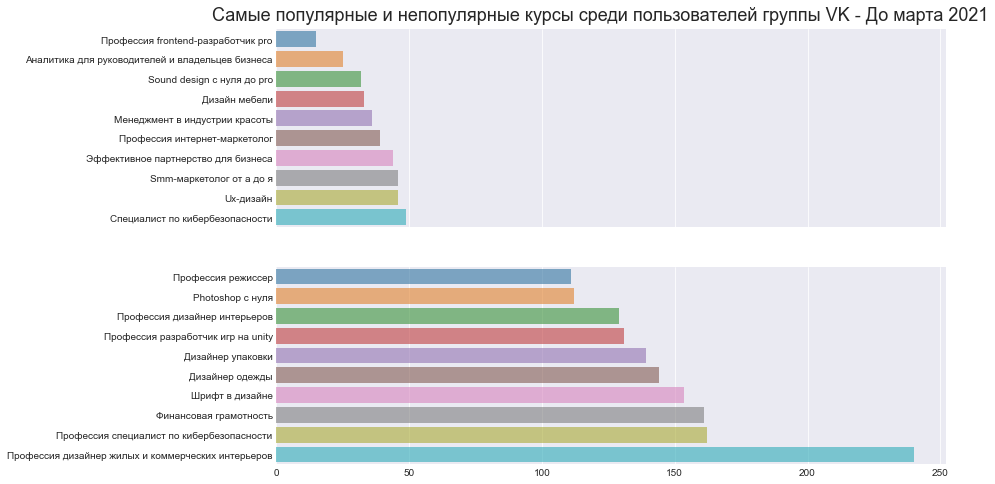

In [35]:
fig, axs = plt.subplots(figsize=(12,8), nrows=2, ncols=1, sharex=True)
fig.suptitle('Самые популярные и непопулярные курсы среди пользователей группы VK - До марта 2021', fontsize=18, y=0.92)

data = course_data_old.head(10)
data1 = course_data_old.tail(10)
sns.barplot(data=data, y='course', x='likes', ax = axs[0], alpha=0.6, ci=None)\
            .set(ylabel=None, xlabel=None)
sns.barplot(data=data1, y='course', x='likes', ax = axs[1], alpha=0.6, ci=None)\
            .set(ylabel=None, xlabel=None)
g.set(xlabel=None, ylabel=None)
g.tick_params(labelsize=12)

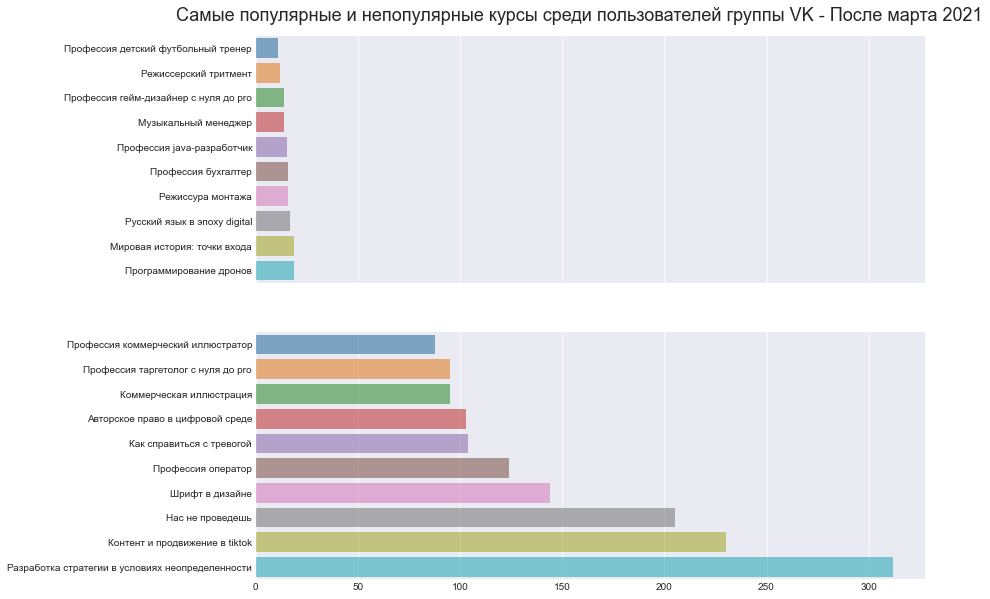

In [36]:
fig, axs = plt.subplots(figsize=(12,10), nrows=2, ncols=1, sharex=True)
fig.suptitle('Самые популярные и непопулярные курсы среди пользователей группы VK - После марта 2021', fontsize=18, y=0.92)

data = course_data_new.head(10)
data1 = course_data_new.tail(10)
sns.barplot(data=data, y='course', x='likes', ax = axs[0], alpha=0.6, ci=None)\
            .set(ylabel=None, xlabel=None)
sns.barplot(data=data1, y='course', x='likes', ax = axs[1], alpha=0.6, ci=None)\
            .set(ylabel=None, xlabel=None)
g.set(xlabel=None, ylabel=None)
g.tick_params(labelsize=12)

- Рассматривая период с марта 2020 до марта 2021 года, самыми непопулярными постами стали посты, рассказывающие о курсах Frontend-разработки, аналитики, Sound дизайна, дизайна мебели. 
- Также пользователей не таки сильно интересовали курсы SMM-маркетолога и интернет-маркетолога, UX-дизайна, которые сейчас являются одиними из самых популярных направлений в Skillbox. 
- Болший интерес среди пользователей в 2020-начале 2021 года вызывали посты о курсах Дизайна: начиная от дизайна жилых и коммерческих интерьеров, заканчивая курсом по дизайну упаковки, шрифтами в дизайне и Photoshop. 
- Также польователи часто лайкали посты о курсах о финансовой граммотности, кибербезопасности и разработке игр. 
- С ростом популярности сервисов TikTok, Instagram сменились интересы аудитории паблика Skillbox. Если до марта 2021 года пользователей не сильно интересовали курсы продвижения, то уже в 2021 году мы видим большой интерес к теме продвижения контента в TikTok, освоению провессии оператора и сторисмейкера и таргетолога.
- Пользователи интересуются курсами по авторскому праву в цифровой среде и коммерческой иллюстрации, что также связно с популярностью таких профессий как блогер, сторисмейкер и т.д
- С марта 2021 года пользователи поставили меньше всего лайков курсам по музыкальному менеджменту, режиссуре монтажа.
- Посты, рассказывающие о таких курсах как "Программирование дронов", "Java-разработчик", "Гейм-дизайн" и "Профессия Футбольный тренер" получили меньше 50 лайков.

### 3. Выводы на основании рассчитанных данных
- За последние годы активность пользователей группы VK снизилась: аудитория неактивно комментирует посты, ставит меньше лайков, несмотря на смену визуала в паблике. Можно предположить, что пользователи используют VK для сохранения полезной информации, так как количество репостов повысилось. Это подтверждает также тот факт, что посты по тематике "Полезная информация" репостятся чаще. 
- Посты, опубликованные в вечернее время привлекают больше внимания, чем посты, опубликованные, к примеру, в обеденное время. 
- Хэштеги, которые используются при публикации не имеют единый формат, что делает навигацию по паблику не совсем удобной. Так, мы видим, что посты с полезной информацией публикуются с хэштегами: #в_закладки_skillbox, #skillbox_взакладки, #взакладкиskillbox. В ситуации, если пользователь захочет найти все посты по этой теме, он этого сделать не сможет. С учетом вышеизложенных пунктов (использование VK в качестве дополнительного источника полезной информации) единый формат хэштегов, а также сокращение их количества поможет в привлечении аудитории.  
- Можно заметить, что пользователей больше привлекают посты с бОльшим количеством медиа.Использование одного типа аттачмента (только фото/только видео) привлекает больше лайков, чем различные (фото+видео, фото/видео+опрос, фото/видео+документ, фото/видео+ссылка)
- Возможно, администраторам паблика стоит обратить внимание на публикацию информации о курсах, которые не пользуются популярностью, делая их более привлекательными для потенциальных студентов. 